# Interpretable AI Project

Done by Saul Vassallo and David Scerri

In [1]:
!pip install git+https://github.com/tensorflow/docs
!pip install pdpbox
!pip install alibi[tensorflow]
!pip install tf-explain
!pip install mmd_critic

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-k20gkgf6
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-k20gkgf6
  Resolved https://github.com/tensorflow/docs to commit c221d1e1af1ef5cc37c4a0879876f25f9cc1d981
  Preparing metadata (setup.py) ... done


In [2]:
# TensorFlow
import tensorflow as tf
from tensorflow import keras
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tf_explain.core.grad_cam import GradCAM

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Criticism
from mmd_critic import MMDCritic
from mmd_critic.kernels import RBFKernel

# Commonly used modules
import numpy as np
import os
import cv2
from pdpbox import pdp
from time import time

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython
from six.moves import urllib
from alibi.explainers import IntegratedGradients, Counterfactual
from alibi.utils.visualization import visualize_image_attr
from scipy.ndimage import gaussian_filter

from google.colab import drive

print(tf.__version__)

2.14.1


In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)

## Cifar-10 Model

Function to unpickle the CIFAR-10 dataset files... taken from README.html

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

Load CIFAR-10 Dataset and Preprocess

In [6]:
def load_cifar10(folder_path):
    x_train = []
    y_train = []
    for i in range(1, 6):
        batch = unpickle(os.path.join(folder_path, f"data_batch_{i}"))
        x_train.append(batch[b'data'])
        y_train.extend(batch[b'labels'])

    x_train = np.concatenate(x_train)
    y_train = np.array(y_train)

    test_batch = unpickle(os.path.join(folder_path, "test_batch"))
    x_test = test_batch[b'data']
    y_test = np.array(test_batch[b'labels'])

    # Reshape and normalize
    x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype('float32') / 255.0
    x_test = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype('float32') / 255.0

    return (x_train, y_train), (x_test, y_test)

In [7]:
cifar10_folder = '/content/drive/My Drive/InterpretableAI/cifar-10/'
(x_train, y_train), (x_test, y_test) = load_cifar10(cifar10_folder)

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [8]:
class_names = [
    "airplane", "automobile", "bird", "cat",
    "deer", "dog", "frog", "horse", "ship", "truck"
]

Define CNN Architecture

In [9]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

Compile CNN model

In [10]:
cnn_model.compile(optimizer = 'adam',
         loss = 'categorical_crossentropy',
         metrics = ['acc'])

Train the Model

Epoch 1/500
176/176 [==============================] - 92s 492ms/step - loss: 1.7792 - acc: 0.3443 - val_loss: 1.4924 - val_acc: 0.4584
Epoch 2/500
176/176 [==============================] - 64s 360ms/step - loss: 1.3978 - acc: 0.4966 - val_loss: 1.3033 - val_acc: 0.5302
Epoch 3/500
176/176 [==============================] - 69s 392ms/step - loss: 1.2615 - acc: 0.5498 - val_loss: 1.2175 - val_acc: 0.5642
Epoch 4/500
176/176 [==============================] - 63s 357ms/step - loss: 1.1617 - acc: 0.5906 - val_loss: 1.1409 - val_acc: 0.5986
Epoch 5/500
176/176 [==============================] - 64s 366ms/step - loss: 1.0888 - acc: 0.6146 - val_loss: 1.0633 - val_acc: 0.6260
Epoch 6/500
176/176 [==============================] - 67s 384ms/step - loss: 1.0268 - acc: 0.6385 - val_loss: 1.0504 - val_acc: 0.6332
Epoch 7/500
176/176 [==============================] - 61s 348ms/step - loss: 0.9754 - acc: 0.6585 - val_loss: 1.0179 - val_acc: 0.6470
Epoch 8/500
176/176 [===========================

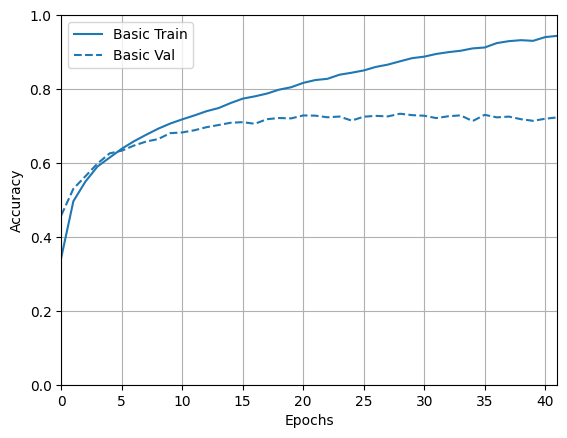

In [11]:
history = cnn_model.fit(x_train, y_train, epochs = 500, validation_split = 0.1, batch_size = 256, callbacks = [early_stop])

plotter = tfdocs.plots.HistoryPlotter(metric = 'acc')
plotter.plot({'Basic': history}, metric = 'acc')
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.show()

## Part 4: Interpretable AI for Computer Vision


### 1. Integrated Gradient

Initialise Integrated Gradients

In [12]:
ig = IntegratedGradients(cnn_model, n_steps=50, method="gausslegendre", internal_batch_size=50)

In [13]:
image_index = 6
instance = np.expand_dims(x_test[image_index], axis=0)

Make prediction of image

In [14]:
predicted_probs = cnn_model.predict(instance)
predicted_label_index = np.argmax(predicted_probs, axis=1)[0]
predicted_label = class_names[predicted_label_index]
print(f"Predicted label for the instance: {predicted_label}")

1/1 [==============================] - 0s 188ms/step
Predicted label for the instance: truck


Compute attributions for the prediction via explenation

In [15]:
explanation = ig.explain(instance, baselines=None, target=[predicted_label_index])

Extract attributions

In [16]:
attrs = explanation.attributions[0]
attrs_smoothed = gaussian_filter(attrs, sigma=0.5)

Visualise the original image and attributions

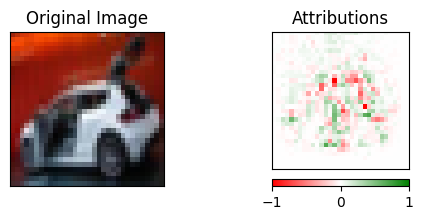

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))

# Original Image
visualize_image_attr(attr=None, original_image=x_test[image_index], method='original_image',
                     title='Original Image', plt_fig_axis=(fig, ax[0]), use_pyplot=False)

# Attributions Heatmap
visualize_image_attr(attr=attrs.squeeze(), original_image=x_test[image_index], method='heat_map',
                     sign='all', show_colorbar=True, title='Attributions',
                     plt_fig_axis=(fig, ax[1]), use_pyplot=True)
plt.show()

### 2. Grad-CAM

In [18]:
# Select an image from the test set
image = x_test[image_index]
label = np.argmax(y_test[image_index])

# Add a batch dimension to the image
image_with_batch = np.expand_dims(image, axis=0)

# Print the true label
print(f"True label index: {label}")

True label index: 1


In [19]:
# Initialize Grad-CAM
grad_cam = GradCAM()

# Define the target layer (adjust based on your CNN model's layer names)
target_layer = 'conv2d'

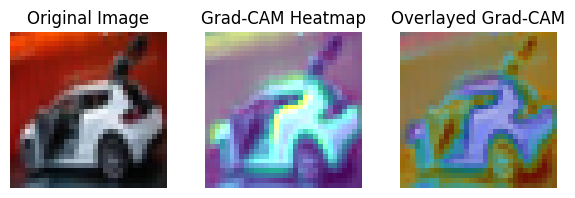

In [20]:
# Compute Grad-CAM heatmap
explanation = grad_cam.explain(
    validation_data=(image_with_batch, None),
    model=cnn_model,
    class_index=label,  # Target class index
    layer_name=target_layer
)

# Normalize the heatmap
heatmap = explanation / np.max(explanation)

# Overlay the heatmap on the original image
overlayed_image = np.uint8(255 * image)  # Rescale original image to 0-255
heatmap_resized = np.uint8(255 * cv2.resize(heatmap, (32, 32)))  # Resize heatmap to match image dimensions
overlayed_image = cv2.addWeighted(overlayed_image, 0.7, cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET), 0.4, 0)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(6, 2))

# Original Image
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis('off')

# Heatmap
ax[1].imshow(heatmap, cmap='jet')
ax[1].set_title("Grad-CAM Heatmap")
ax[1].axis('off')

# Overlayed Grad-CAM
ax[2].imshow(overlayed_image)
ax[2].set_title("Overlayed Grad-CAM")
ax[2].axis('off')

plt.tight_layout()
plt.show()


## Disable Eager mode for the rest of the Assignment

In [21]:
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Boston Housing Model



Load the data

In [22]:
(boston_train_features, boston_train_labels), (boston_test_features, boston_test_labels) = keras.datasets.boston_housing.load_data()

print(boston_train_features.shape)
print(boston_test_features.shape)
print(boston_train_labels.shape)
print(boston_test_labels.shape)

(404, 13)
(102, 13)
(404,)
(102,)


Add the labels back to the dataset for feature engineering

- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per $10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population

- MEDV - Median value of owner-occupied homes in $1000's



In [23]:
boston_feature_names = [
  'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
  'RM', 'AGE', 'DIS', 'RAD', 'TAX',
  'PTRATIO', 'B', 'LSTAT'
]

boston_train_features_df = pd.DataFrame(boston_train_features, columns = boston_feature_names)
boston_test_features_df = pd.DataFrame(boston_test_features, columns = boston_feature_names)

print("Training Dataset Shape:", boston_train_features_df.shape)
print("\nFirst few rows of training data:")
print(boston_train_features_df.head())
print("\nDataset Info:")
print(boston_train_features_df.describe())

Training Dataset Shape: (404, 13)

First few rows of training data:
      CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS   RAD    TAX  \
0  1.23247   0.0   8.14   0.0  0.538  6.142   91.7  3.9769   4.0  307.0   
1  0.02177  82.5   2.03   0.0  0.415  7.610   15.7  6.2700   2.0  348.0   
2  4.89822   0.0  18.10   0.0  0.631  4.970  100.0  1.3325  24.0  666.0   
3  0.03961   0.0   5.19   0.0  0.515  6.037   34.5  5.9853   5.0  224.0   
4  3.69311   0.0  18.10   0.0  0.713  6.376   88.4  2.5671  24.0  666.0   

   PTRATIO       B  LSTAT  
0     21.0  396.90  18.72  
1     14.7  395.38   3.11  
2     20.2  375.52   3.26  
3     20.2  396.90   8.01  
4     20.2  391.43  14.65  

Dataset Info:
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  404.000000  404.000000  404.000000  404.000000  404.000000  404.000000   
mean     3.745111   11.480198   11.104431    0.061881    0.557356    6.267082   
std      9.240734   23.767711    6.811308    0.241238  

Scale non categorical inputs (RAD) and outputs using Z-Score

In [24]:
def z_score_scale(data, columns_to_scale = None, exclude_columns = None):
  """
  Scales columns using sklearn's StandardScaler. Can either specify columns to scale
  or columns to exclude from scaling.

  Args:
    data: pandas DataFrame containing the data
    columns_to_scale: list of column names to scale (optional)
    exclude_columns: list of column names to exclude from scaling (optional)

  Returns:
    DataFrame with scaled columns

  Note:
    If columns_to_scale is provided, exclude_columns is ignored.
    If neither is provided, all columns are scaled.
  """
  scaled_data = data.copy()

  # Determine which columns to scale
  if columns_to_scale is not None:
    # Use specified columns
    columns_to_process = columns_to_scale
  else:
    # Use all columns except excluded ones
    exclude_columns = exclude_columns or []
    columns_to_process = [col for col in data.columns if col not in exclude_columns]

  scaler = StandardScaler()
  scaled_data[columns_to_process] = scaler.fit_transform(data[columns_to_process])
  return scaled_data

boston_train_features_scaled_df = z_score_scale(boston_train_features_df, exclude_columns = ['CHAS'])
boston_test_features_scaled_df = z_score_scale(boston_test_features_df, exclude_columns = ['CHAS'])

scaler = StandardScaler()
boston_train_labels_scaled = scaler.fit_transform(boston_train_labels.reshape(-1, 1))
boston_test_labels_scaled = scaler.fit_transform(boston_test_labels.reshape(-1, 1))

boston_test_df = pd.concat([boston_test_features_scaled_df, pd.DataFrame(boston_test_labels_scaled, columns = ['MEDV'])], axis = 1)

print(boston_train_features_scaled_df.head())
print(boston_test_features_scaled_df.head())


       CRIM        ZN     INDUS  CHAS       NOX        RM       AGE       DIS  \
0 -0.272246 -0.483615 -0.435762   0.0 -0.165227 -0.176443  0.813062  0.116698   
1 -0.403427  2.991784 -1.333912   0.0 -1.215182  1.894346 -1.910361  1.247585   
2  0.124940 -0.483615  1.028326   0.0  0.628642 -1.829688  1.110488 -1.187439   
3 -0.401494 -0.483615 -0.869402   0.0 -0.361560 -0.324558 -1.236672  1.107180   
4 -0.005634 -0.483615  1.028326   0.0  1.328612  0.153642  0.694808 -0.578572   

        RAD       TAX   PTRATIO         B     LSTAT  
0 -0.626249 -0.595170  1.148500  0.448077  0.825220  
1 -0.856463 -0.348433 -1.718189  0.431906 -1.329202  
2  1.675886  1.565287  0.784476  0.220617 -1.308500  
3 -0.511142 -1.094663  0.784476  0.448077 -0.652926  
4  1.675886  1.565287  0.784476  0.389882  0.263497  
       CRIM        ZN     INDUS  CHAS       NOX        RM       AGE       DIS  \
0  2.804030 -0.507849  0.969609   0.0  1.231746  0.119341  1.147398 -0.919353   
1 -0.555306 -0.507849 -0.17

Train on 363 samples, validate on 41 samples
Epoch 1/500
363/363 [==============================] - 0s 461us/sample - loss: 1.5812 - mean_squared_error: 1.5812 - mean_absolute_error: 0.8976 - val_loss: 0.8455 - val_mean_squared_error: 0.8455 - val_mean_absolute_error: 0.6257
Epoch 2/500
363/363 [==============================] - 0s 64us/sample - loss: 1.1959 - mean_squared_error: 1.1959 - mean_absolute_error: 0.7707 - val_loss: 0.5749 - val_mean_squared_error: 0.5749 - val_mean_absolute_error: 0.5473
Epoch 3/500
363/363 [==============================] - 0s 59us/sample - loss: 1.0189 - mean_squared_error: 1.0189 - mean_absolute_error: 0.7080 - val_loss: 0.4324 - val_mean_squared_error: 0.4324 - val_mean_absolute_error: 0.5083
Epoch 4/500
363/363 [==============================] - 0s 61us/sample - loss: 0.8032 - mean_squared_error: 0.8032 - mean_absolute_error: 0.6248 - val_loss: 0.3531 - val_mean_squared_error: 0.3531 - val_mean_absolute_error: 0.4768
Epoch 5/500
363/363 [=============

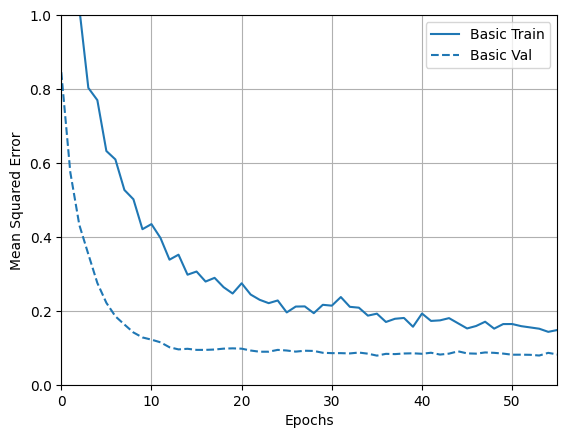

In [25]:
boston_model = keras.Sequential([
  keras.layers.Dense(32, activation = 'relu', input_shape = (13,)),
  keras.layers.Dropout(0.1),
  keras.layers.Dense(1)
])

boston_model.compile(optimizer = 'adam',
           loss = 'mean_squared_error',
           metrics = ['mean_squared_error', 'mean_absolute_error'])

history = boston_model.fit(boston_train_features_scaled_df, boston_train_labels_scaled, epochs = 500, validation_split = 0.1, callbacks = [early_stop])

plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_squared_error')
plotter.plot({'Basic': history}, metric = 'mean_squared_error')
plt.ylim([0, 1])
plt.ylabel('Mean Squared Error')
plt.show()


## Part 1: Feature Level Interpretability



### 1. Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) plots

obtain pred_func from the provided model.


  0%|          | 0/8 [00:00<?, ?it/s]

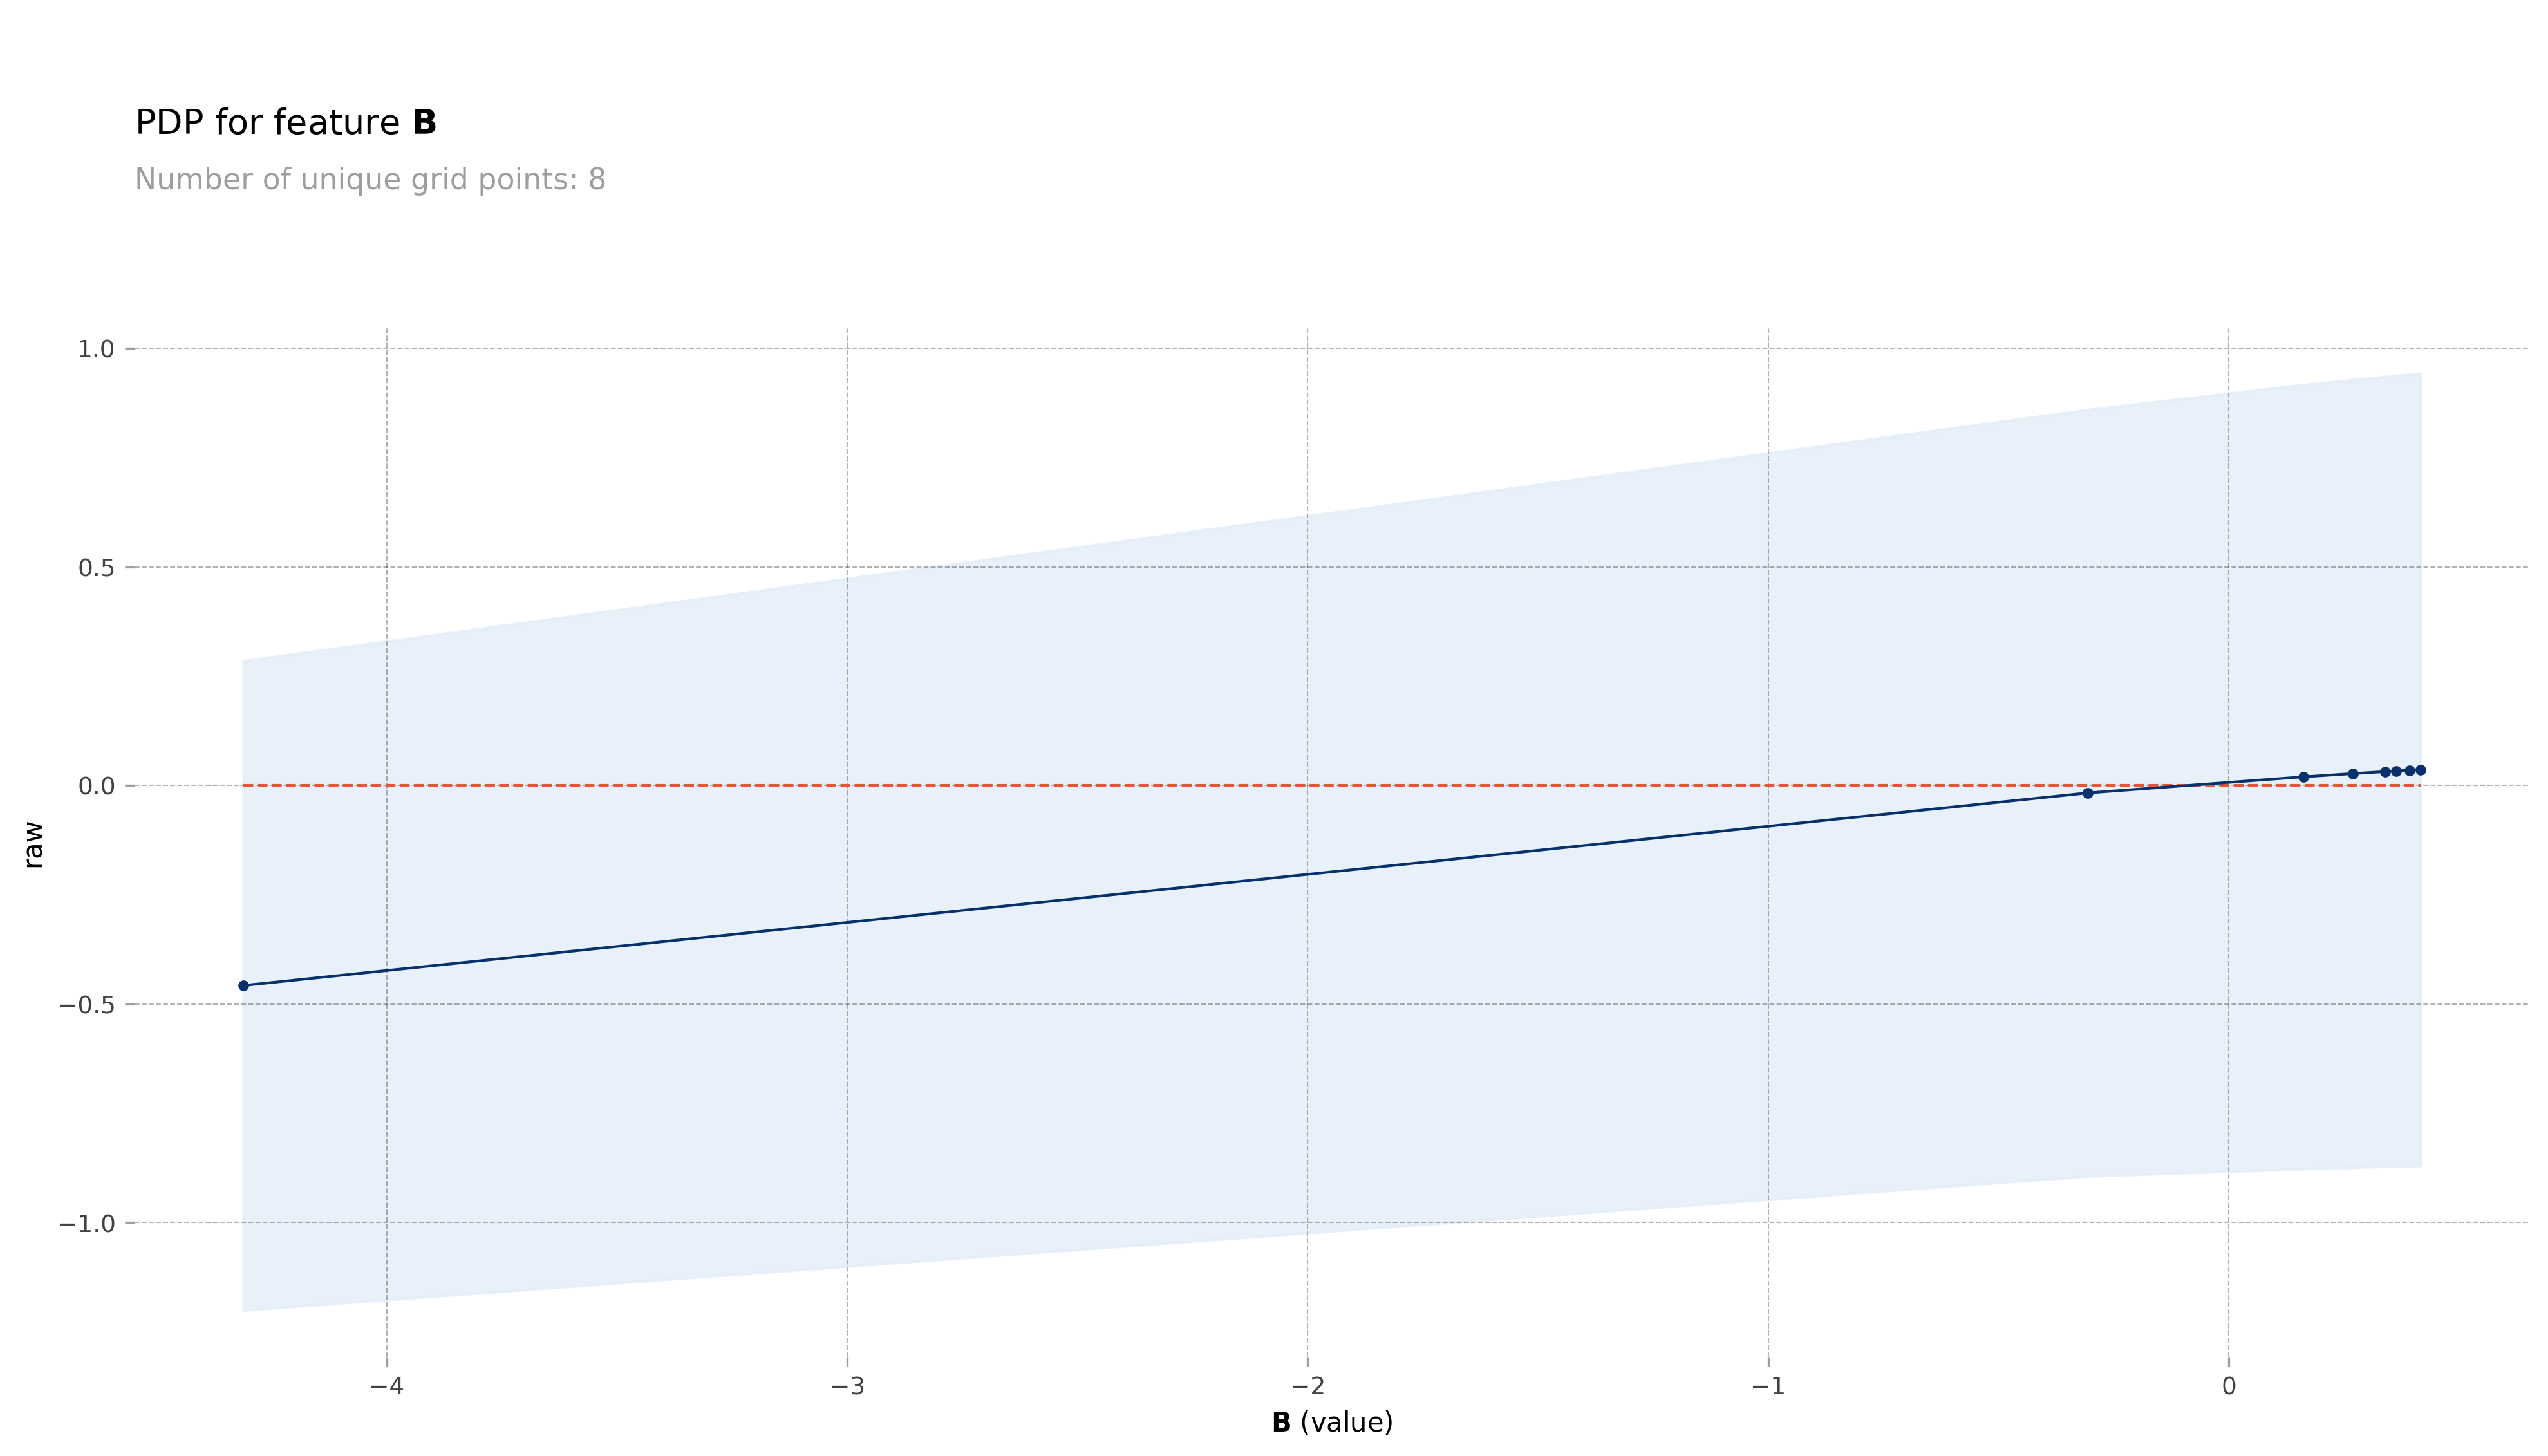

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

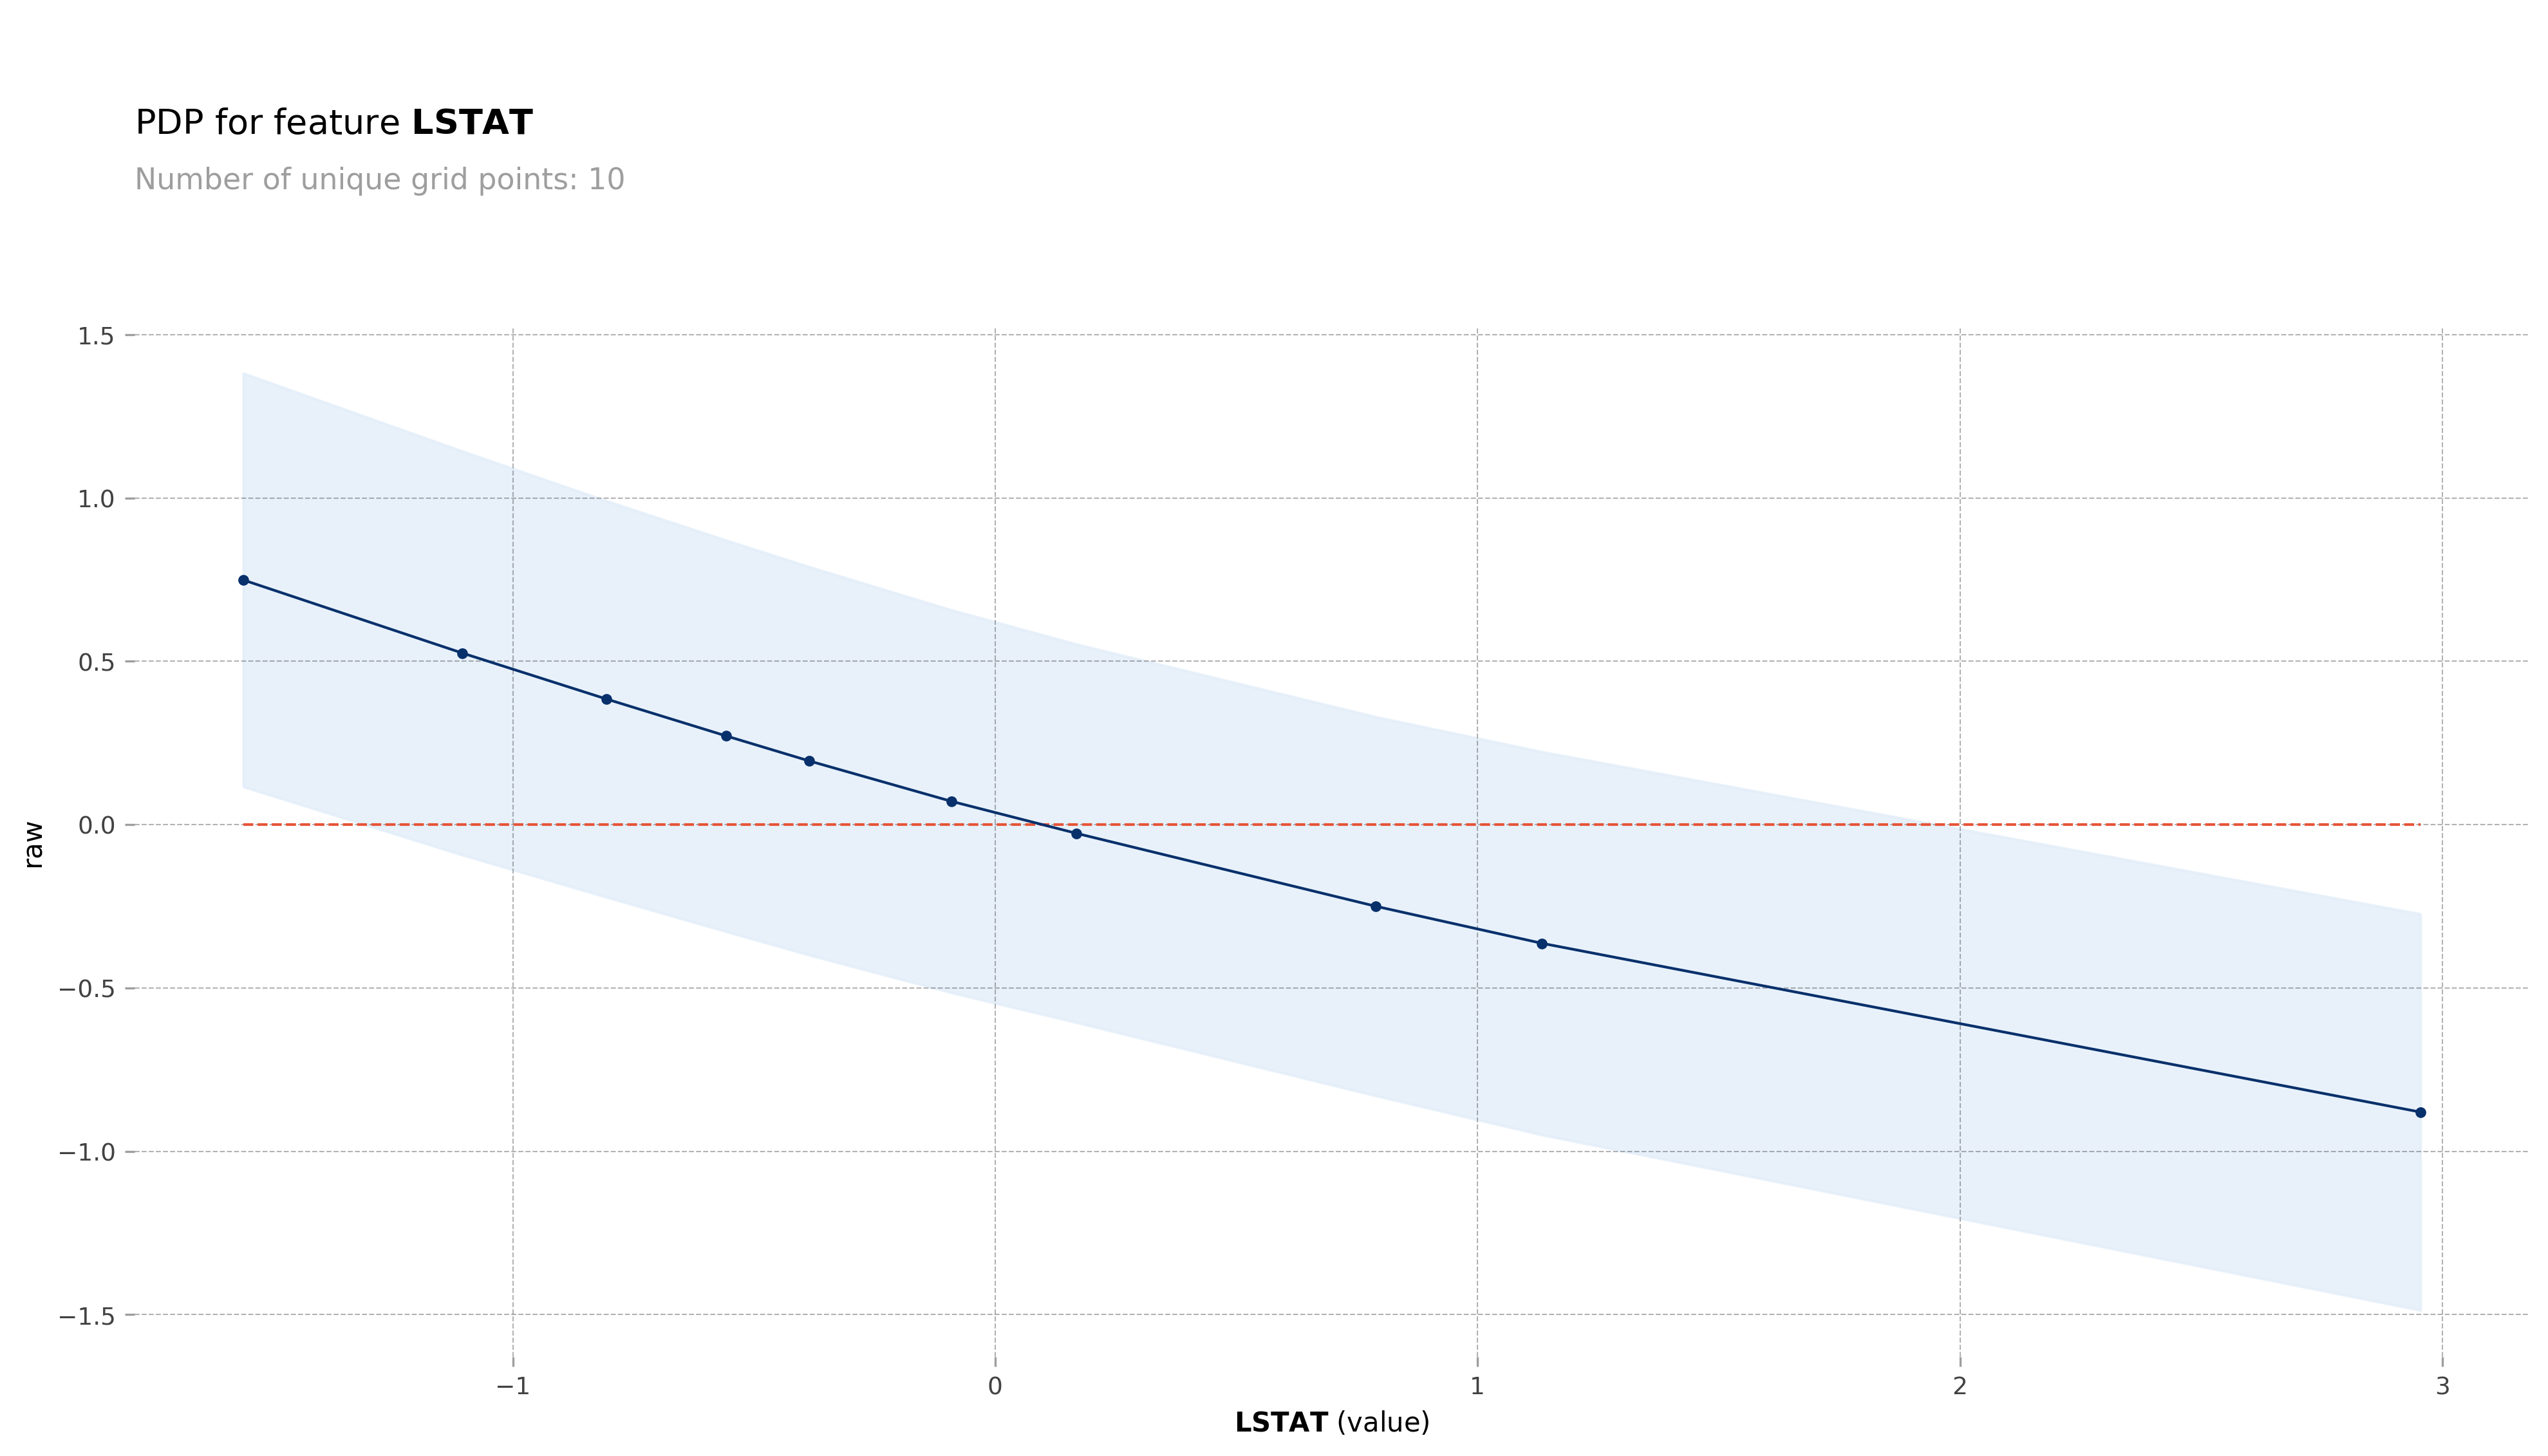

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

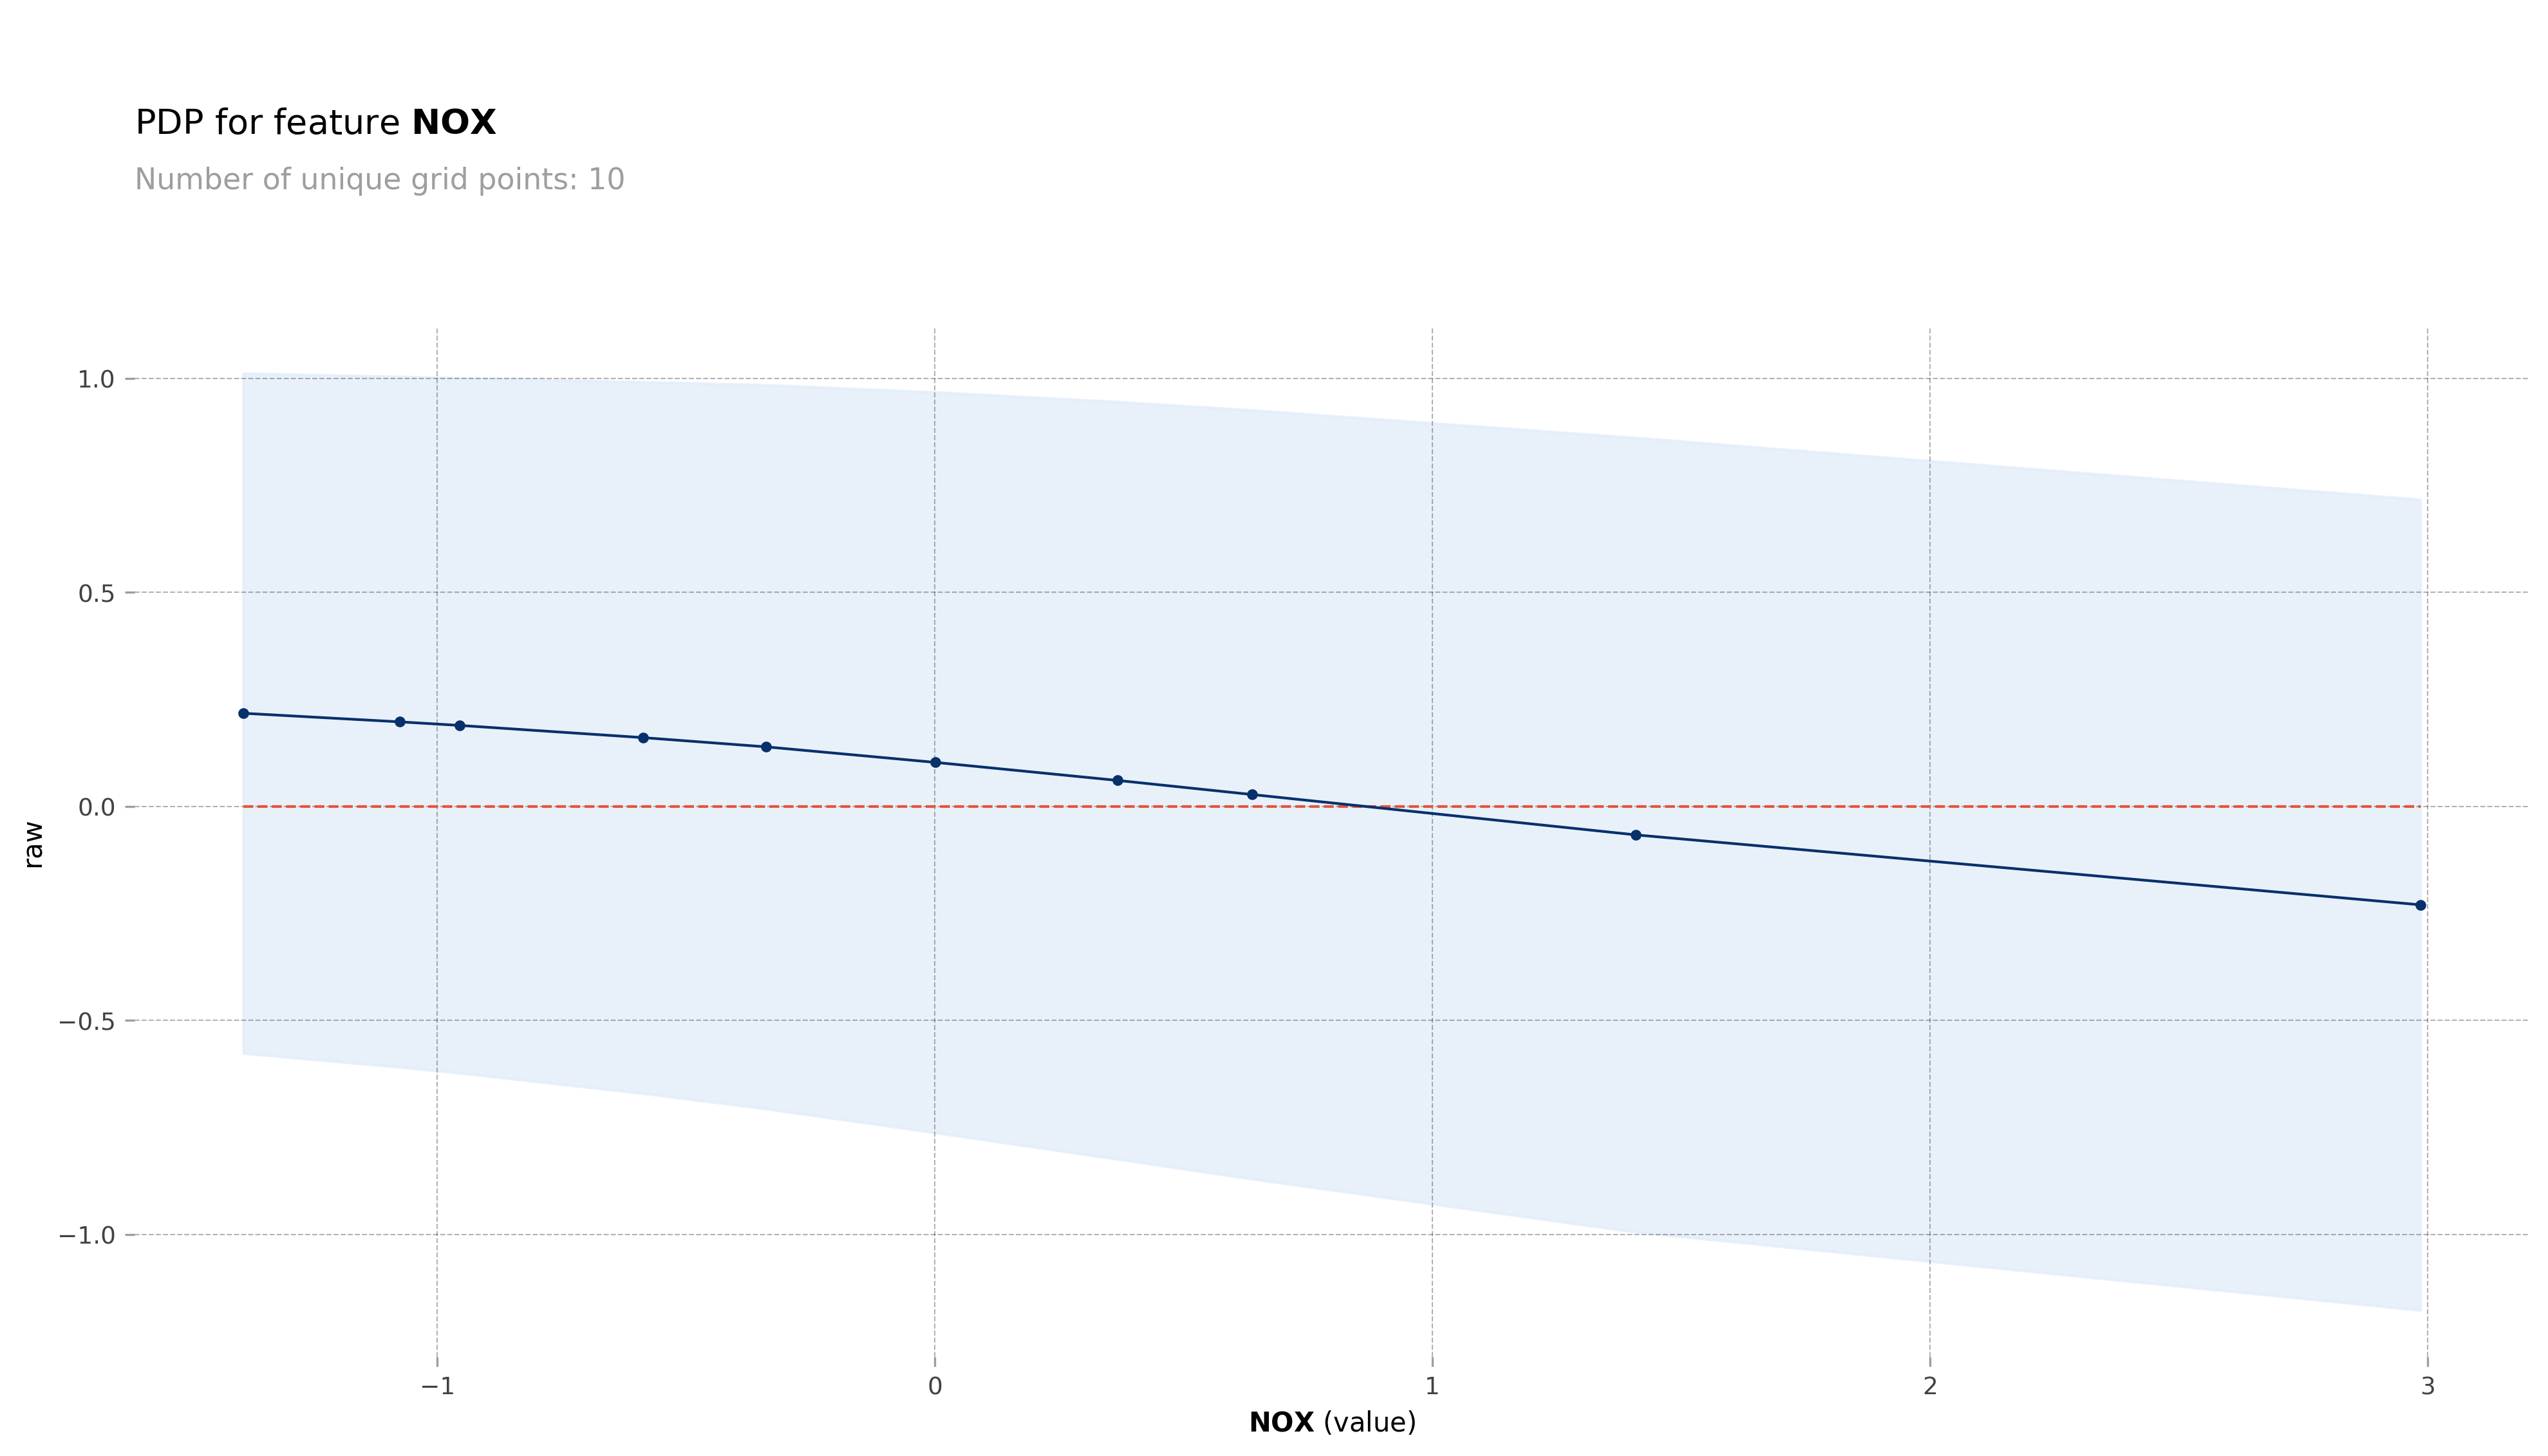

In [26]:
# Create PDPs for selected features
features_to_plot = ['B', 'LSTAT', 'NOX']

for i, feature in enumerate(features_to_plot):

  # Create the PDPBox isolate object
  pdp_isolate = pdp.PDPIsolate(
    model = boston_model,
    df = boston_test_df,
    model_features = boston_feature_names,
    feature = feature,
    feature_name = feature,
    n_classes = 0
  )

  # Plot the PDP
  fig, axes = pdp_isolate.plot(
    center = False,
    plot_lines = False,
    plot_pts_dist = False,
    to_bins = False,
    engine = 'matplotlib'
  )

  plt.tight_layout()
  plt.show()

### 2. Permutation Feature Importance (PFI)

### 3. Accumulated Local Effects (ALE)

### 4. Global Surrogates

## Titanic Model


load data and check nu of nas and na percentages

In [27]:
titanic_train_data = pd.read_csv('/content/drive/My Drive/InterpretableAI/data/titanic/train.csv')
titanic_test_data = pd.read_csv('/content/drive/My Drive/InterpretableAI/data/titanic/test.csv')

print(titanic_train_data.shape)
print(titanic_test_data.shape)

# Check NA values in training data
print("NA values in training data:")
print(titanic_train_data.isna().sum())

print("\nNA values in test data:")
print(titanic_test_data.isna().sum())

# Percentage of NA values in training data
print("\nPercentage of NA values in training data:")
print((titanic_train_data.isna().sum() / len(titanic_train_data)) * 100)

print("\nPercentage of NA values in test data:")
print((titanic_test_data.isna().sum() / len(titanic_test_data)) * 100)

print(titanic_train_data.head())
print(titanic_test_data.head())


(891, 12)
(418, 11)
NA values in training data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

NA values in test data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Percentage of NA values in training data:
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

Percentage of NA values in test data:
PassengerId     0.000000
Pclass          0.000000
Name            0

Drop non-numerical columns

In [28]:
# Feature engineering

# Drop unnecessary columns
titanic_train_data = titanic_train_data.drop(columns = ['Name', 'Ticket', 'Cabin', 'PassengerId'])
titanic_test_data = titanic_test_data.drop(columns = ['Name', 'Ticket', 'Cabin', 'PassengerId'])

print(titanic_train_data.head())
print(titanic_test_data.head())


   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S
   Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0       3    male  34.5      0      0   7.8292        Q
1       3  female  47.0      1      0   7.0000        S
2       2    male  62.0      0      0   9.6875        Q
3       3    male  27.0      0      0   8.6625        S
4       3  female  22.0      1      1  12.2875        S


Encode categorical columns

In [29]:
def encode_features(data):
  mappings = {}
  for column in data.columns:
    if data[column].dtype == 'object':
      le = LabelEncoder()
      data[column] = le.fit_transform(data[column])
      # Store the mapping
      mappings[column] = dict(zip(le.classes_, le.transform(le.classes_)))
      print(f"\nMapping for {column}:")
      for original, encoded in mappings[column].items():
        print(f"{original} → {encoded}")
  return data

titanic_train_data = encode_features(titanic_train_data)
titanic_test_data = encode_features(titanic_test_data)


print(titanic_train_data.head())
print(titanic_test_data.head())


Mapping for Sex:
female → 0
male → 1

Mapping for Embarked:
C → 0
Q → 1
S → 2
nan → 3

Mapping for Sex:
female → 0
male → 1

Mapping for Embarked:
C → 0
Q → 1
S → 2
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         0       3    1  22.0      1      0   7.2500         2
1         1       1    0  38.0      1      0  71.2833         0
2         1       3    0  26.0      0      0   7.9250         2
3         1       1    0  35.0      1      0  53.1000         2
4         0       3    1  35.0      0      0   8.0500         2
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0       3    1  34.5      0      0   7.8292         1
1       3    0  47.0      1      0   7.0000         2
2       2    1  62.0      0      0   9.6875         1
3       3    1  27.0      0      0   8.6625         2
4       3    0  22.0      1      1  12.2875         2


Deal with NA values by replacing them with their means and dropping the 2 in embarked col

In [30]:
titanic_train_data = titanic_train_data[titanic_train_data['Embarked'] != 3]

titanic_train_data = titanic_train_data.fillna(titanic_train_data.mean())
titanic_test_data = titanic_test_data.fillna(titanic_test_data.mean())

Scale non-categorical values using z-score

In [31]:
titanic_train_data = z_score_scale(titanic_train_data, ['Age', 'Fare', 'SibSp', 'Parch'])
titanic_test_data = z_score_scale(titanic_test_data, ['Age', 'Fare', 'SibSp', 'Parch'])

print(titanic_train_data.head())
print(titanic_test_data.head())

   Survived  Pclass  Sex       Age     SibSp     Parch      Fare  Embarked
0         0       3    1 -0.589620  0.431350 -0.474326 -0.500240         2
1         1       1    0  0.644848  0.431350 -0.474326  0.788947         0
2         1       3    0 -0.281003 -0.475199 -0.474326 -0.486650         2
3         1       1    0  0.413385  0.431350 -0.474326  0.422861         2
4         0       3    1  0.413385 -0.475199 -0.474326 -0.484133         2
   Pclass  Sex       Age     SibSp     Parch      Fare  Embarked
0       3    1  0.334993 -0.499470 -0.400248 -0.498407         1
1       3    0  1.325530  0.616992 -0.400248 -0.513274         2
2       2    1  2.514175 -0.499470 -0.400248 -0.465088         1
3       3    1 -0.259330 -0.499470 -0.400248 -0.483466         2
4       3    0 -0.655545  0.616992  0.619896 -0.418471         2


Separate labels and features for training

In [32]:
titanic_train_features = titanic_train_data.drop(columns = ['Survived'])
titanic_train_labels = titanic_train_data['Survived'].values

titanic_test_features = titanic_test_data

Train the Model

In [33]:
# One-hot encode the reset labels
titanic_train_labels = to_categorical(titanic_train_labels, num_classes=2)
print(f"One-hot encoded labels shape: {titanic_train_labels.shape}")

One-hot encoded labels shape: (889, 2)


In [34]:
print(f"Features shape: {titanic_train_features.shape}")
print(f"Labels shape: {titanic_train_labels.shape}")

Features shape: (889, 7)
Labels shape: (889, 2)


Train on 800 samples, validate on 89 samples
Epoch 1/500
800/800 [==============================] - 0s 318us/sample - loss: 0.6819 - acc: 0.6187 - val_loss: 0.6026 - val_acc: 0.6742
Epoch 2/500
800/800 [==============================] - 0s 62us/sample - loss: 0.6318 - acc: 0.6338 - val_loss: 0.5714 - val_acc: 0.6742
Epoch 3/500
800/800 [==============================] - 0s 69us/sample - loss: 0.6022 - acc: 0.6513 - val_loss: 0.5477 - val_acc: 0.6966
Epoch 4/500
800/800 [==============================] - 0s 75us/sample - loss: 0.5658 - acc: 0.6913 - val_loss: 0.5242 - val_acc: 0.7191
Epoch 5/500
800/800 [==============================] - 0s 78us/sample - loss: 0.5470 - acc: 0.7175 - val_loss: 0.5070 - val_acc: 0.7753
Epoch 6/500
800/800 [==============================] - 0s 75us/sample - loss: 0.5367 - acc: 0.7200 - val_loss: 0.4903 - val_acc: 0.7978
Epoch 7/500
800/800 [==============================] - 0s 87us/sample - loss: 0.5213 - acc: 0.7688 - val_loss: 0.4767 - val_acc: 0.7978
Ep

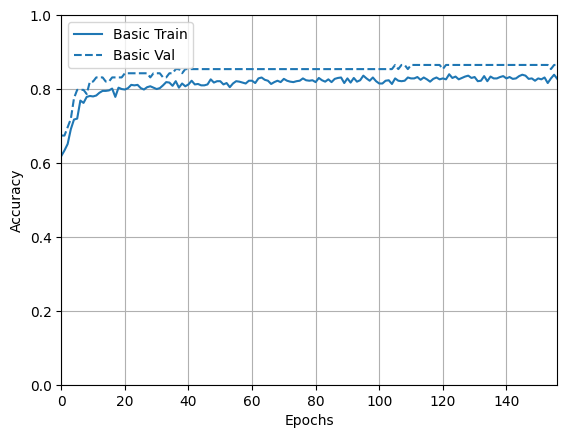

In [35]:
titanic_model = tf.keras.Sequential([
  tf.keras.layers.Dense(32, activation = 'relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(2, activation = 'softmax')
])

titanic_model.compile(optimizer = 'adam',
           loss = 'categorical_crossentropy',
           metrics = ['acc'])

history = titanic_model.fit(
    titanic_train_features.values,
    titanic_train_labels,
    epochs=500,
    validation_split=0.1,
    batch_size=32,
    callbacks=[early_stop]
)


plotter = tfdocs.plots.HistoryPlotter(metric = 'acc')
plotter.plot({'Basic': history}, metric = 'acc')
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.show()

## Part 2: Local Interpretability Techniques

### 1. Local Interpretable Model-agnostic Explanations (LIME)

### 2. Shapley Additive Explanations (SHAP)

### 3. Anchors

## Part 3: Example-Based Explanations

### 1. Counterfactual Explanations

Normalize test data and check dimensions

In [36]:
X_test = titanic_test_features.values
X_test_norm = (X_test - X_test.min(axis=0)) / (X_test.max(axis=0) - X_test.min(axis=0))

shape = titanic_train_features.shape[1]

print(f"Expected input dimensions for Counterfactual: {shape}")
print(f"Actual input dimensions being passed: {X_test_norm.shape}")

Expected input dimensions for Counterfactual: 7
Actual input dimensions being passed: (418, 7)


Define the counterfactual generator

In [37]:
cf = Counterfactual(titanic_model,
                    shape=(1, shape),
                    distance_fn='l1',         # L1 distance for sparse changes
                    target_proba=0.5,         # target probability for the desired class
                    max_iter=1000,            # maximum iterations
                    lam_init=1e-1,            # regularization term
                    learning_rate_init=1e-2,  # learning rate
                    feature_range=(0, 1)      # range of feature values (normalized)
                   )

Split data and predict training data

In [38]:
X_train = titanic_train_features.values
y_train = np.argmax(titanic_train_labels, axis=1)

In [39]:
train_predictions = titanic_model.predict(X_train)
train_predicted_classes = np.argmax(train_predictions, axis=1)

Identify incorrect predictions

In [40]:
train_incorrect_indices = np.where(train_predicted_classes != y_train)[0]

print(f"Number of incorrect predictions in training data: {len(train_incorrect_indices)}")
print(f"First 10 incorrect prediction indices: {train_incorrect_indices[:10]}")

Number of incorrect predictions in training data: 144
First 10 incorrect prediction indices: [14 17 18 21 23 25 36 40 41 49]


Select first two and generate counterfactuals

In [41]:
selected_train_indices = train_incorrect_indices[:2]

for idx in selected_train_indices:
    instance = X_train[idx].reshape(1, -1)
    explanation = cf.explain(instance)

    print(f"\nIndex: {idx}")
    print("Original Instance (scaled):", instance[0])
    print("Counterfactual Instance (scaled):", explanation.cf['X'][0])
    print(f"Original Prediction: {train_predicted_classes[idx]} (probability: {train_predictions[idx][train_predicted_classes[idx]]:.2f})")
    print(f"Counterfactual Prediction: {np.argmax(explanation.cf['X'][0])}")
    print("Feature Changes (scaled):", explanation.cf['X'][0] - instance[0])
    print("=" * 50)


Index: 14
Original Instance (scaled): [ 3.          0.         -1.20685378 -0.47519908 -0.47432585 -0.48807536
  2.        ]
Counterfactual Instance (scaled): [1.        0.5974976 0.        0.        0.        0.        1.       ]
Original Prediction: 1 (probability: 0.71)
Counterfactual Prediction: 0
Feature Changes (scaled): [-2.          0.59749758  1.20685378  0.47519908  0.47432585  0.48807536
 -1.        ]

Index: 17
Original Instance (scaled): [ 2.00000000e+00  1.00000000e+00 -5.48213849e-16 -4.75199081e-01
 -4.74325852e-01 -3.84474648e-01  2.00000000e+00]
Counterfactual Instance (scaled): [1.         0.72932565 0.         0.         0.         0.
 1.        ]
Original Prediction: 0 (probability: 0.84)
Counterfactual Prediction: 0
Feature Changes (scaled): [-1.00000000e+00 -2.70674348e-01  5.48213849e-16  4.75199081e-01
  4.74325852e-01  3.84474648e-01 -1.00000000e+00]


Visualise both instances

In [42]:
def visualize_counterfactual(index, original, counterfactual, features):
    changes = counterfactual - original

    plt.figure(figsize=(10, 6))
    x = np.arange(len(features))

    plt.bar(x - 0.2, original, width=0.4, label='Original Instance', color='blue')
    plt.bar(x + 0.2, counterfactual, width=0.4, label='Counterfactual Instance', color='orange')

    for i, change in enumerate(changes):
        if change != 0:
            plt.text(x[i], max(original[i], counterfactual[i]) + 0.05, f'{change:.2f}',
                     ha='center', va='bottom', fontsize=12, color='red')

    plt.xticks(x, features, rotation=45, ha='right')
    plt.ylabel('Feature Value (Scaled)')
    plt.title(f'Counterfactual Visualization for Instance {index}')
    plt.legend()
    plt.tight_layout()
    plt.show()

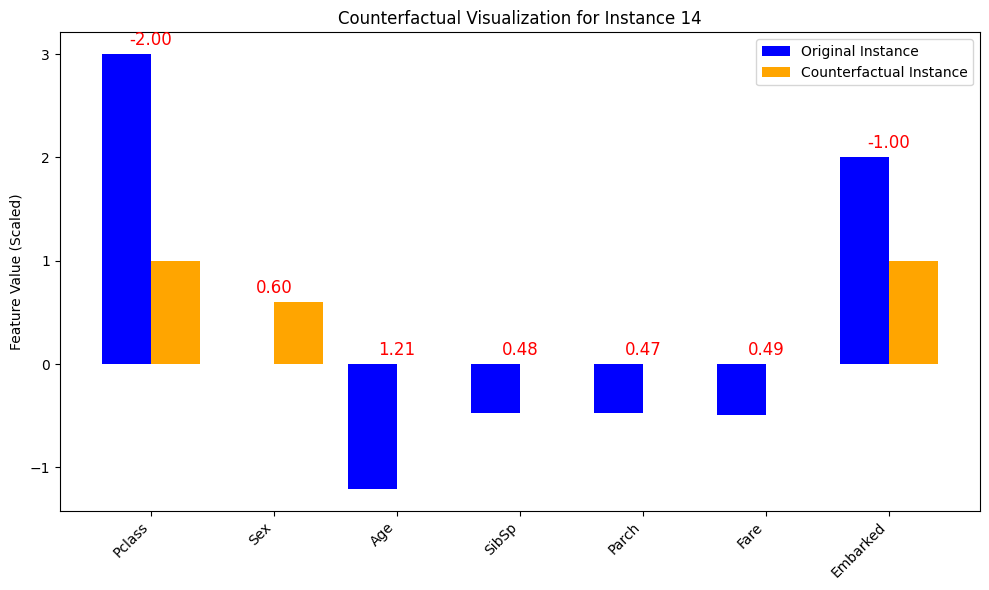

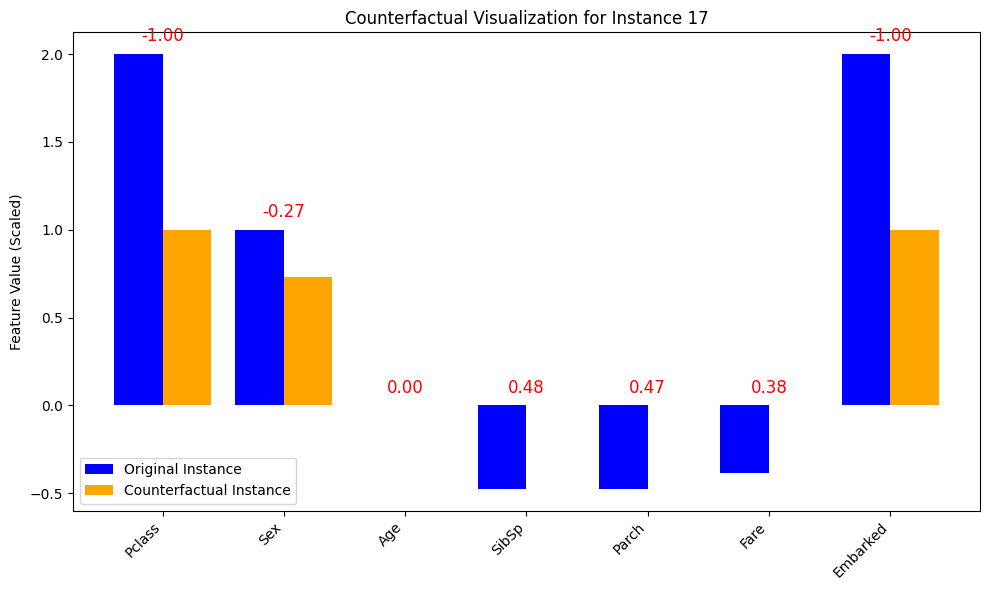

In [43]:
feature_names = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

for idx in selected_train_indices:
    original = X_train[idx]
    counterfactual = cf.explain(original.reshape(1, -1)).cf['X'][0]
    visualize_counterfactual(idx, original, counterfactual, feature_names)

### 2. Prototypes and Criticisms

Convert to list of lists

In [44]:
X_list = titanic_train_data.values.tolist()
print(f"Preprocessed Titanic data shape: {len(X_list)} samples with {len(X_list[0])} features")

Preprocessed Titanic data shape: 889 samples with 8 features


Initialise MMDCritic

In [45]:
critic = MMDCritic(X_list, RBFKernel(1), RBFKernel(0.025))

Select 5 prototypes and 10 criticisms

In [46]:
protos, _ = critic.select_prototypes(5)

print(f"Selected 5 prototypes:")
for i, proto in enumerate(protos):
    print(f"Prototype {i + 1}: {proto}")

Selected 5 prototypes:
Prototype 1: [ 0.          3.          1.         -0.12669441 -0.47519908 -0.47432585
 -0.45494036  2.        ]
Prototype 2: [ 1.          1.          1.          0.49053951 -0.47519908 -0.47432585
 -0.11494329  2.        ]
Prototype 3: [ 1.          3.          0.         -0.58961986 -0.47519908 -0.47432585
 -0.49017322  1.        ]
Prototype 4: [ 0.          3.          1.          1.64785311 -0.47519908 -0.47432585
 -0.4841333   2.        ]
Prototype 5: [ 0.          2.          1.         -0.6667741   0.43135024 -0.47432585
 -0.41467424  2.        ]


In [47]:
criticisms, _ = critic.select_criticisms(10, protos)

print(f"Selected 10 criticisms:")
for i, crit in enumerate(criticisms):
    print(f"Criticism {i + 1}: {crit}")

Selected 10 criticisms:
Criticism 1: [ 1.          1.          1.          0.49053951 -0.47519908 -0.47432585
 -0.1169566   2.        ]
Criticism 2: [ 0.          3.          1.          1.64785311 -0.47519908 -0.47432585
 -0.49017322  2.        ]
Criticism 3: [ 0.          3.          1.         -0.12669441 -0.47519908 -0.47432585
 -0.48723782  2.        ]
Criticism 4: [ 0.          3.          1.         -0.12669441 -0.47519908 -0.47432585
 -0.48723782  2.        ]
Criticism 5: [ 0.          3.          1.         -0.12669441 -0.47519908 -0.47432585
 -0.48807536  2.        ]
Criticism 6: [ 0.          3.          1.         -0.12669441 -0.47519908 -0.47432585
 -0.48925113  2.        ]
Criticism 7: [ 0.          3.          1.          1.64785311 -0.47519908 -0.47432585
 -0.5041818   2.        ]
Criticism 8: [ 0.00000000e+00  3.00000000e+00  1.00000000e+00 -5.48213849e-16
 -4.75199081e-01 -4.74325852e-01 -4.87237820e-01  2.00000000e+00]
Criticism 9: [ 0.00000000e+00  3.00000000e+00  1

Visualise prototypes and criticism

In [48]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(np.array(X_list))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
protos_pca = pca.transform(np.array(protos))
criticisms_pca = pca.transform(np.array(criticisms))

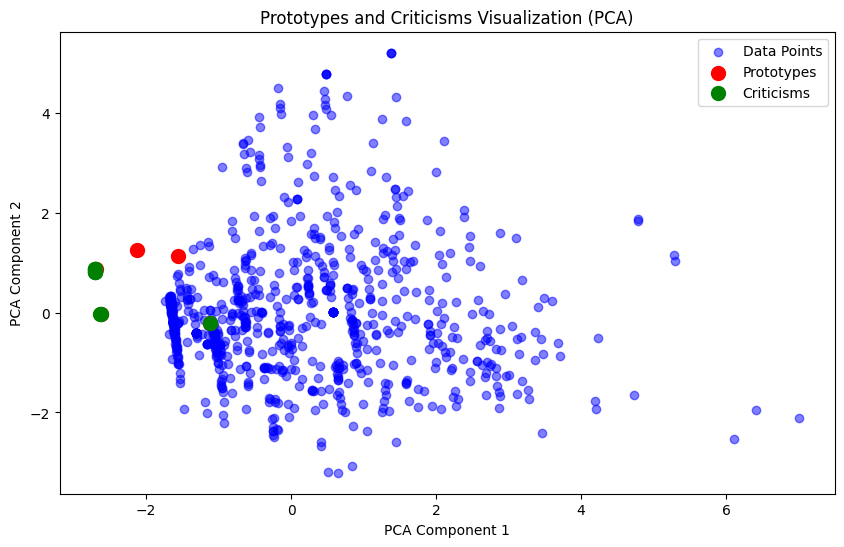

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='b', alpha=0.5, label='Data Points')
plt.scatter(protos_pca[:, 0], protos_pca[:, 1], c='r', label='Prototypes', s=100)
plt.scatter(criticisms_pca[:, 0], criticisms_pca[:, 1], c='g', label='Criticisms', s=100)
plt.title('Prototypes and Criticisms Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

====================================================================================================